# Colorized Voronoi

This notebook has an associated tutorial that can be found [here](). 



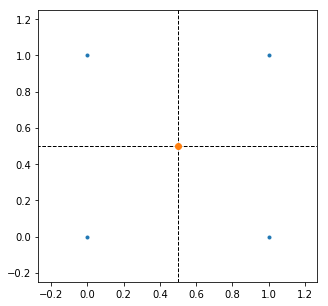

In [1]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
%matplotlib inline

# Calculate Voronoi Polygons 
square = [(0, 0), (0, 1), (1, 1), (1, 0)]
vor = Voronoi(square)

def simple_voronoi(vor, saveas=None, lim=None):
    # Make Voronoi Diagram 
    fig = voronoi_plot_2d(vor, show_points=True, show_vertices=True, s=4)

    # Configure figure 
    fig.set_size_inches(5,5)
    plt.axis("equal")
    
    if lim:
        plt.xlim(*lim)
        plt.ylim(*lim)
    
    if saveas:
        plt.savefig("../pics/%s.png"%saveas)

    plt.show()

simple_voronoi(vor, saveas="square", lim=(-0.25,1.25))

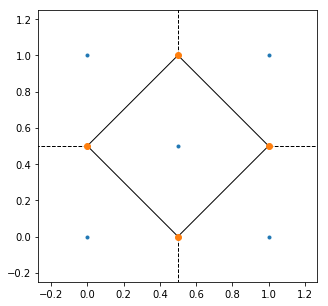

In [2]:
five = [(0, 0), (0, 1), (1, 1), (1, 0), (0.5, 0.5)]
vor = Voronoi(five)

simple_voronoi(vor, saveas="five", lim=(-0.25,1.25))

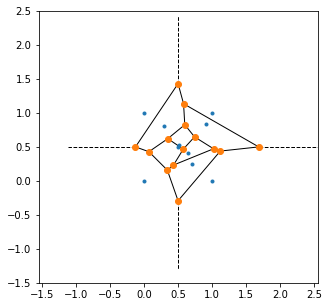

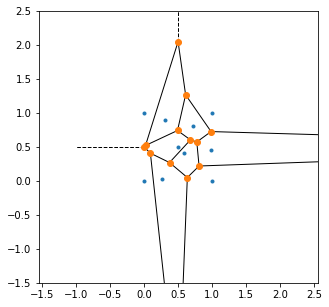

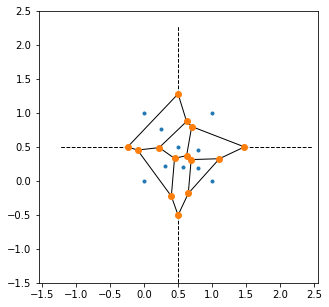

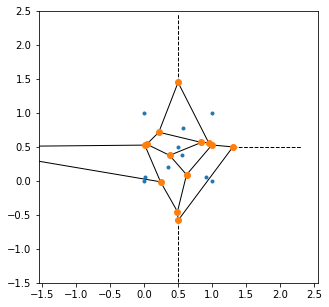

In [3]:
import numpy as np 

n_randoms = 5

for i in range(4):
    randos = five + np.random.rand(n_randoms, 2).tolist()
    vor = Voronoi(randos)
    simple_voronoi(vor, lim=(-1.5,2.5), saveas="rand%s"%i)


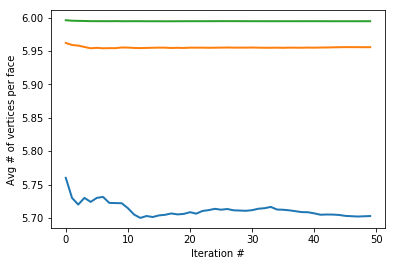

In [4]:
# experiment to show that the number of vertices per cell is on average <6 

def random_voro(n_seeds):
    randos = np.random.rand(n_seeds, 2)
    vor = Voronoi(randos)
    return vor


for n_seeds in [100, 1000, 10000]:
    S = N = 0
    avgs = []
    raws = []
    for i in range(50):
        vor = random_voro(n_seeds)
        S += sum([len(l) for l in vor.regions]) / (len(vor.regions)-1)
        N = i+1
        avgs.append(S/N)
        raws.append(sum([len(l) for l in vor.regions]) / (len(vor.regions)-1))
    plt.xlabel("Iteration #")
    plt.ylabel("Avg # of vertices per face")
    plt.plot(avgs, linewidth=2)
    #plt.scatter(range(len(raws)), raws, s=0.1)
plt.show()

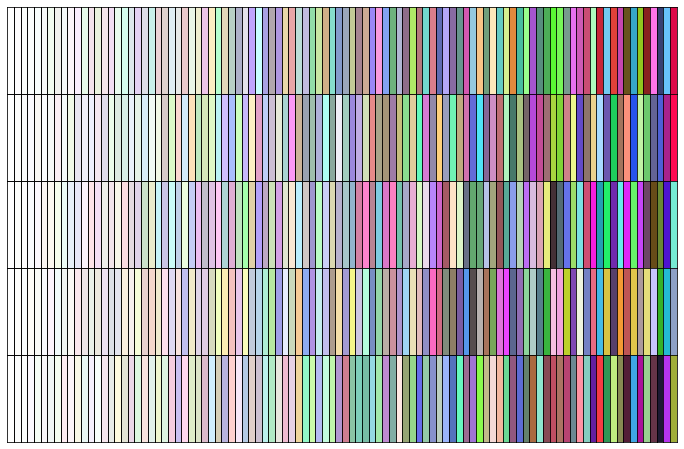

In [5]:
import random
def random_color(as_str=True, alpha=0.5):
    rgb = [random.randint(0,255),
           random.randint(0,255),
           random.randint(0,255)]
    if as_str:
        return "rgba"+str(tuple(rgb+[alpha]))
    else:
        return list(np.array(rgb)/255) + [alpha]
    
def test_random_color(gridsize=(5,100), figsize=(12,8)):
    fig, axarr = plt.subplots(*gridsize, figsize=figsize)
    for i, ax in enumerate(axarr.flatten()):
        # Remove ticks
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
        # Calculate alpha as normlized column # 
        alpha = (i % gridsize[1]) / (gridsize[1] - 1)
        ax.set_facecolor(random_color(as_str=False, alpha=alpha))
    
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.savefig("../pics/test_random_color.png")
    plt.show()

test_random_color()

In [6]:

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    Source
    -------
    Copied from https://gist.github.com/pv/8036995
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max() * 2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def voronoi_polygons(n=50):
    """Generates Voronoi polygons with n randomly-generated seeds"""
    random_seeds = np.random.rand(n, 2)
    vor = Voronoi(random_seeds)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    polygons = []
    for reg in regions:
        polygon = vertices[reg]
        polygons.append(polygon)
    return polygons

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def plot_polygons(polygons, ax=None, alpha=0.5, linewidth=0.7, saveas=None, show=True):
    # Configure plot 
    if ax is None:
        plt.figure(figsize=(5,5))
        ax = plt.subplot(111)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    ax.axis("equal")
    
    # Set limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
    # Add polygons 
    for poly in polygons:
        colored_cell = Polygon(poly,
                               linewidth=linewidth, 
                               alpha=alpha,
                               facecolor=random_color(as_str=False, alpha=1),
                               edgecolor="black")
        ax.add_patch(colored_cell)

    if not saveas is None:
        plt.savefig(saveas)
    if show:
        plt.show()
    
    return ax 

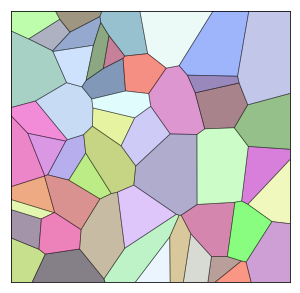

In [8]:
plot_polygons(voronoi_polygons(), saveas="../pics/test_voro.png")

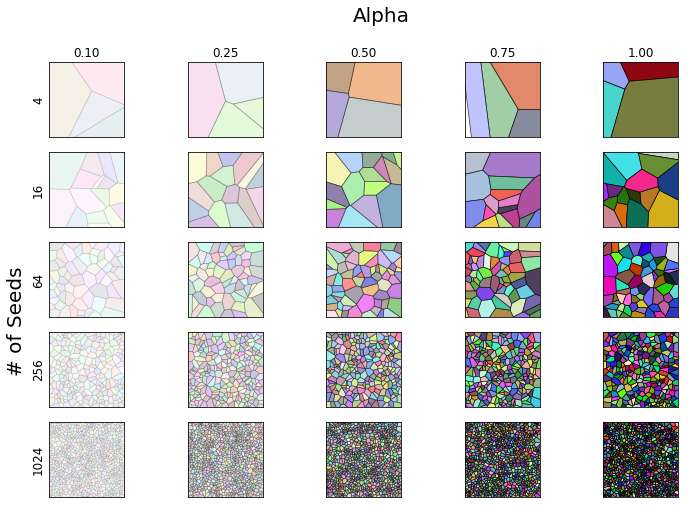

In [9]:
def test_plot(gridsize=(5,5), figsize=(12,8)):
    fig, axarr = plt.subplots(*gridsize, figsize=figsize)
    for i in range(axarr.shape[0]):
        for j in range(axarr.shape[1]):
            ax = axarr[i,j]
            
            
            alpha = (j % gridsize[1]) / (gridsize[1] - 1) 
            # Set lower bound for alpha 
            if alpha==0: alpha+=0.1
                
            num_seeds = 4**(i+1)
            
            plot_polygons(voronoi_polygons(n = num_seeds), 
                          ax, 
                          alpha = alpha,
                          show = False)
            ax.set_aspect("equal","box")
            
            if j == 0: ax.set_ylabel("%d"%(num_seeds), size="large", rotation=90)
            if i == 0: ax.set_title("%.2f"%(alpha))
            
    fig.text(x=0.5, y=0.95, s="Alpha", size=20)
    fig.text(x=0.1, y=0.50, s="# of Seeds", size=20, rotation=90)
            
    plt.savefig("../pics/test_plot.png")
    plt.show()
    
test_plot()